In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tensorflow import keras
from tensorflow.keras import layers
from sklearn import model_selection
import tensorflow as tf
from sklearn.neural_network import MLPClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.preprocessing import MinMaxScaler
import itertools

In [2]:
df_data = pd.read_csv(r'D:\kaggle\input\dataset_phishing.csv')
#y=[1 if mail=='legitimate' else 0 for mail in data.status]
df_data.shape
df_data.head(5)
df_data['target'] = pd.get_dummies(df_data['status'])['legitimate'].astype('int')
df_data.drop('status',axis = 1, inplace=True)
df_data[['url','target']].head(5)

tmp = df_data.isnull().sum().reset_index(name='missing_val')
tmp[tmp['missing_val']!= 0]

,index,missing_val


In [4]:
likely_cat = {}
for var in df_data.iloc[:,1:].columns:
    likely_cat[var] = 1.*df_data[var].nunique()/df_data[var].count() < 0.002 

num_cols = []
cat_cols = []
for col in likely_cat.keys():
    if (likely_cat[col] == False):
        num_cols.append(col)
    else:
        cat_cols.append(col)

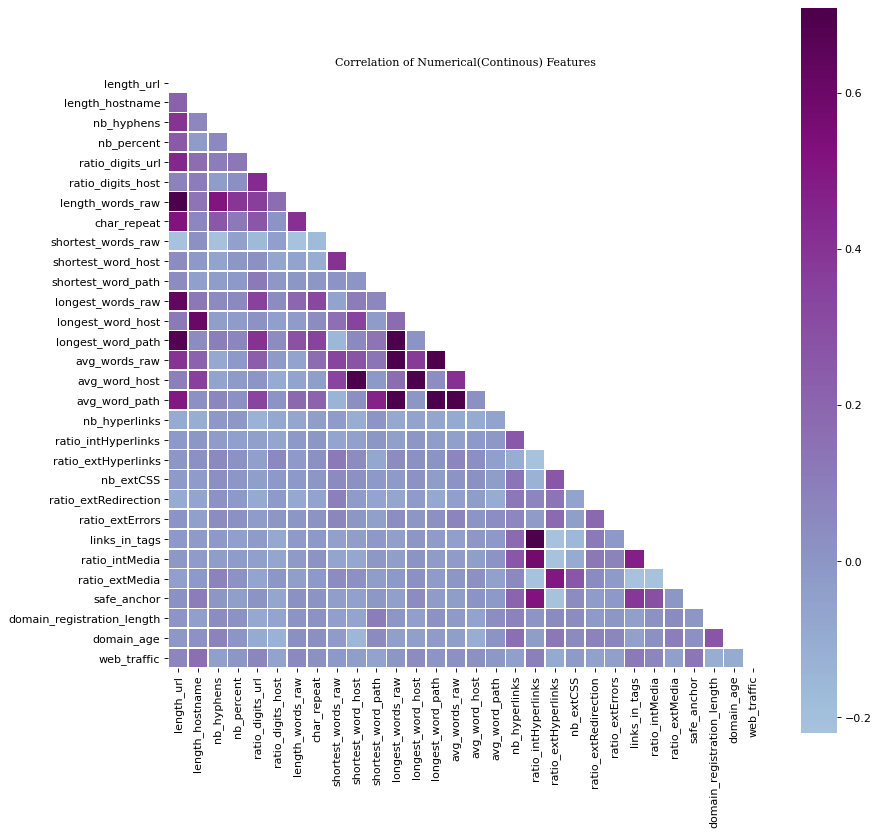

In [5]:
#Taking all columns except URL 
corr = df_data[num_cols].corr()

fig = plt.figure(figsize=(12,12),dpi=80)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='BuPu', robust=True, center=0,
            square=True, linewidths=.5)
plt.title('Correlation of Numerical(Continous) Features', fontsize=15,font="Serif")
plt.show()


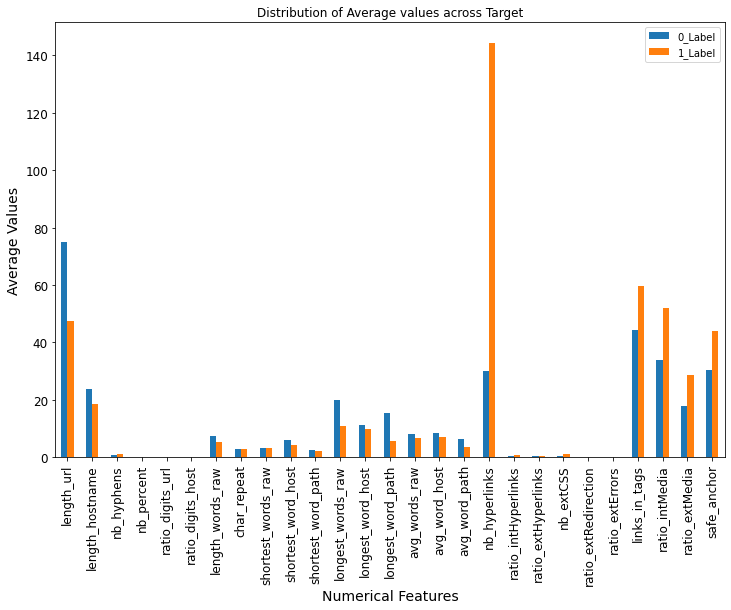

In [9]:
df_distr =df_data.groupby('target')[num_cols].mean().reset_index().T
df_distr.rename(columns={0:'0_Label',1:"1_Label"}, inplace=True)

#plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
ax = df_distr[1:-3][['0_Label','1_Label']].plot(kind='bar', title ="Distribution of Average values across Target", figsize=(12, 8), legend=True, fontsize=12)
ax.set_xlabel("Numerical Features", fontsize=14)
ax.set_ylabel("Average Values", fontsize=14)
#ax.set_ylim(0,500000)
plt.show()

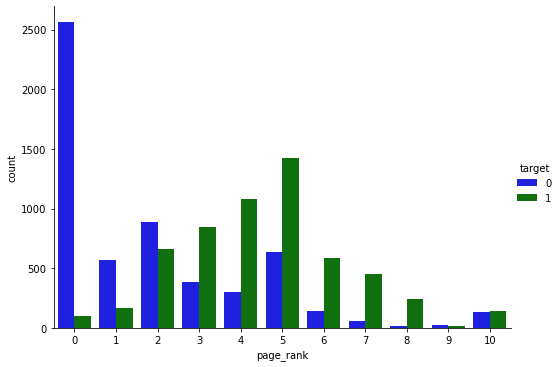

In [10]:
sns.catplot("page_rank", hue="target", data=df_data, kind="count", 
            palette={1:"green", 0:"blue"} ,height=5.0, aspect=11.7/8.27 )

In [11]:
A = df_data.copy()

b = A.pop('target')
#X = data.drop(columns=['url','target','nb_underscore','nb_or','sfh','punycode'])
A = df_data.drop(columns=['url','target'])

#scaler = MinMaxScaler()
#A = scaler.fit_transform(A)

A_train, A_valid, b_train, b_valid = \
    train_test_split(A, b, stratify=b, train_size=0.7)


inputt_shape = [A_train.shape[1]]
print("Input shape is ", inputt_shape)
#A.head()



Input shape is  [87]


In [18]:
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.7)
X_train = np.expand_dims(X_train, axis=2)
X_valid = np.expand_dims(X_valid, axis=2)

input_shape = [X_train[1].shape]
print("Input shape is ", input_shape)

print(X_train.shape)
print(X_train)


Input shape is  [(87, 1)]
(8000, 87, 1)
[[[0.02823818]
  [0.06666667]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.4       ]]

 [[0.02455494]
  [0.19047619]
  [0.        ]
  ...
  [0.        ]
  [1.        ]
  [0.5       ]]

 [[0.03621854]
  [0.1952381 ]
  [0.        ]
  ...
  [0.        ]
  [1.        ]
  [0.        ]]

 ...

 [[0.01903008]
  [0.05714286]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.7       ]]

 [[0.02455494]
  [0.05714286]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.7       ]]

 [[0.01718846]
  [0.07142857]
  [0.        ]
  ...
  [0.        ]
  [1.        ]
  [0.        ]]]


In [19]:
#Train & Test Set
X= df_data.iloc[: , 1:-1]
#y = upsampled_df['Churn']
y= df_data['target']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#train_x,test_x,train_y,test_y = train_test_split(X,y,random_state=42)
#print("\n--Training data samples--")
#print(train_x.shape)

In [20]:

#i am joining the lstm and cnn models
model = keras.Sequential([
    layers.BatchNormalization(input_shape=(87, 1)),
    layers.Conv1D(filters=64,kernel_size=7,activation='relu'),
    layers.BatchNormalization(),
    #layers.Conv1D(filters=32,kernel_size=3,activation='relu'),
    #layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2) ,
    layers.Dropout(0.3),
    
    layers.LSTM(100),
    layers.Dropout(0.3),
    layers.Flatten(), # flatten out the layers
    layers.Dense(512,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 87, 1)             4         
_________________________________________________________________
conv1d (Conv1D)              (None, 81, 64)            512       
_________________________________________________________________
batch_normalization_1 (Batch (None, 81, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 40, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               66000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0

In [16]:
param_grid = {

    "n_estimators":[100,200,300,400],

    "max_depth":[1,3,5,7],

    "reg_lambda":[.01,.1,.5]    

}

grid_model = model_selection.GridSearchCV(

    estimator = model,

    param_grid = param_grid,

    scoring = 'accuracy',

    verbose = 10,

    n_jobs = 1,

    cv = 5    

)

In [24]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]

In [25]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS,
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=20,
    callbacks=[early_stopping],
)




Epoch 1/20
16/16 [==============================] - 47s 2s/step - loss: 0.5784 - accuracy: 1.0000 - precision: 0.7630 - recall: 0.7710 - auc: 0.8444 - val_loss: 0.6898 - val_accuracy: 1.0000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.7652
Epoch 2/20
16/16 [==============================] - 24s 2s/step - loss: 0.4204 - accuracy: 1.0000 - precision: 0.8459 - recall: 0.8317 - auc: 0.9047 - val_loss: 0.6909 - val_accuracy: 1.0000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.8209
Epoch 3/20
16/16 [==============================] - 24s 2s/step - loss: 0.3817 - accuracy: 1.0000 - precision: 0.8600 - recall: 0.8447 - auc: 0.9169 - val_loss: 0.7048 - val_accuracy: 1.0000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.8152
Epoch 4/20
16/16 [==============================] - 25s 2s/step - loss: 0.3556 - accuracy: 1.0000 - precision: 0.8692 - recall: 0.8590 - auc: 0.9266 - val_loss: 0.7082 - val_accuracy: 1.0000 - val_precision: 0.5000 - val_recall: 1.0000 - 

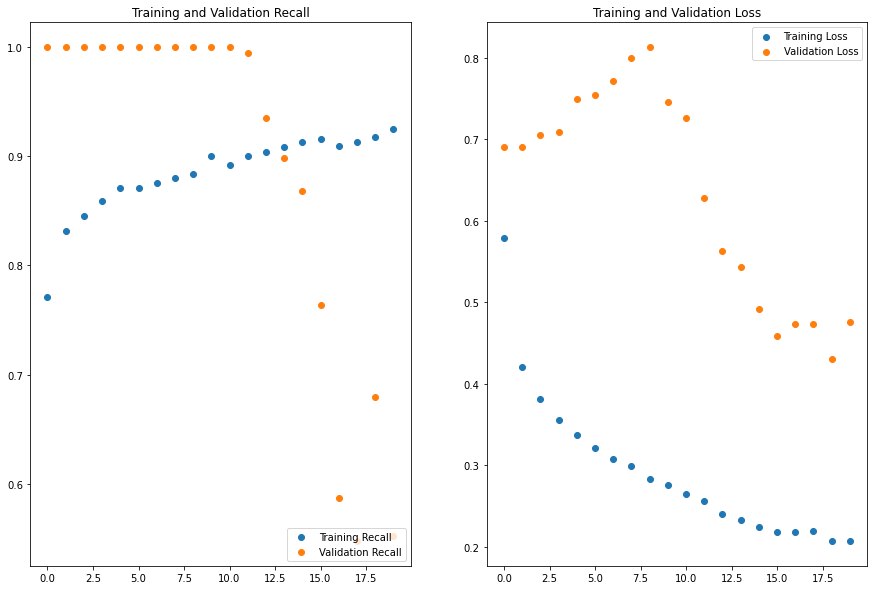

In [26]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range, acc, label='Training Recall')
plt.scatter(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range, loss, label='Training Loss')
plt.scatter(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

              precision    recall  f1-score   support

         0.0       0.95      0.68      0.79      2398
         1.0       0.55      0.92      0.69      1032

    accuracy                           0.75      3430
   macro avg       0.75      0.80      0.74      3430
weighted avg       0.83      0.75      0.76      3430



0.7513119533527697

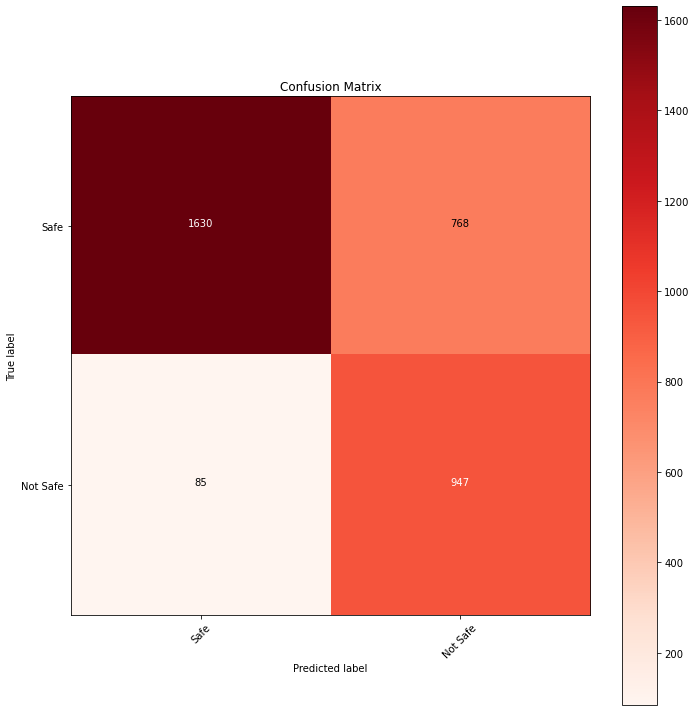

In [27]:
y_pred1 = model.predict(X_valid).reshape(-1)
#print (y_pred1[:5])
y_pred1 = np.round(y_pred1)
print ( classification_report(y_pred1, y_valid))
cm1 = confusion_matrix(y_pred1, y_valid)


def plot_confusion_matrix1(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
target_names = ["Safe", "Not Safe"]
plot_confusion_matrix1(cm1, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(y_valid, y_pred1)


In [28]:
#Deep learning model
model1 = keras.Sequential([
    layers.BatchNormalization(input_shape=inputt_shape),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])


In [29]:

model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS,
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.01,
    restore_best_weights=True,
)
history1 = model1.fit(
    A_train, b_train,
    validation_data=(A_valid, b_valid),
    batch_size=512,
    epochs=20,
    callbacks=[early_stopping],
)

Epoch 1/20
16/16 [==============================] - 12s 276ms/step - loss: 0.3065 - accuracy: 1.0000 - precision: 0.8799 - recall: 0.7858 - auc: 0.9324 - val_loss: 0.3855 - val_accuracy: 1.0000 - val_precision: 0.9758 - val_recall: 0.6350 - val_auc: 0.9619
Epoch 2/20
16/16 [==============================] - 2s 132ms/step - loss: 0.1773 - accuracy: 1.0000 - precision: 0.9385 - recall: 0.9392 - auc: 0.9819 - val_loss: 0.3448 - val_accuracy: 1.0000 - val_precision: 0.9779 - val_recall: 0.6950 - val_auc: 0.9705
Epoch 3/20
16/16 [==============================] - 2s 131ms/step - loss: 0.1301 - accuracy: 1.0000 - precision: 0.9518 - recall: 0.9530 - auc: 0.9884 - val_loss: 0.2950 - val_accuracy: 1.0000 - val_precision: 0.9740 - val_recall: 0.7878 - val_auc: 0.9766
Epoch 4/20
16/16 [==============================] - 2s 128ms/step - loss: 0.1178 - accuracy: 1.0000 - precision: 0.9531 - recall: 0.9595 - auc: 0.9913 - val_loss: 0.2802 - val_accuracy: 1.0000 - val_precision: 0.9786 - val_recall: 

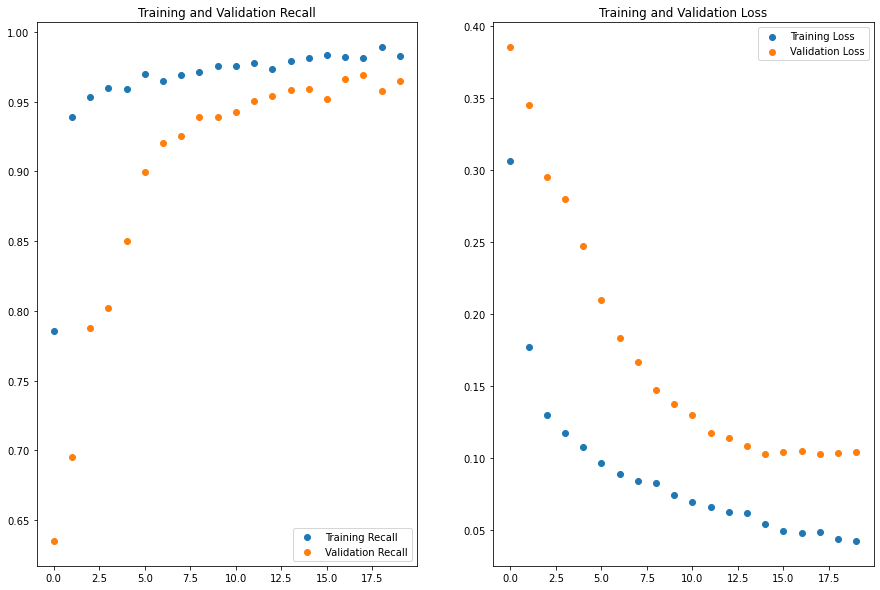

In [30]:
acc1 = history1.history['recall']
val_acc1 = history1.history['val_recall']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
epochs_range1 = range(len(history1.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range1, acc1, label='Training Recall')
plt.scatter(epochs_range1, val_acc1, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range1, loss1, label='Training Loss')
plt.scatter(epochs_range1, val_loss1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      1710
         1.0       0.97      0.96      0.96      1720

    accuracy                           0.96      3430
   macro avg       0.96      0.96      0.96      3430
weighted avg       0.96      0.96      0.96      3430



0.9635568513119533

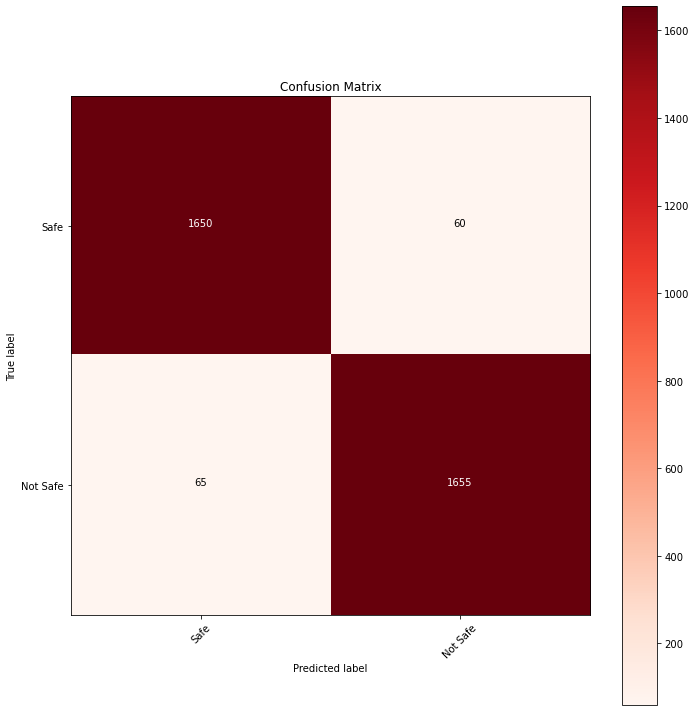

In [34]:
y_pred2 = model1.predict(A_valid).reshape(-1)
#print (y_pred1[:5])
y_pred2 = np.round(y_pred2)
print ( classification_report(y_pred2, b_valid))
cm2 = confusion_matrix(y_pred2, b_valid)


def plot_confusion_matrix1(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
target_names = ["Safe", "Not Safe"]
plot_confusion_matrix1(cm2, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(b_valid, y_pred2)


In [36]:


# Create model object
clf = MLPClassifier(hidden_layer_sizes=(6,5),random_state=5,verbose=True,learning_rate_init=0.01)
#sfs1 = sfs(clf, k_features=4, forward=True, verbose=2, scoring='neg_mean_squared_error')
# Fit data onto the model
clf.fit(A_train,b_train)

y_pred3=clf.predict(A_valid)
accuracy_score(b_valid,y_pred3)


Iteration 1, loss = 2.91817654
Iteration 2, loss = 0.69465787
Iteration 3, loss = 0.67767041
Iteration 4, loss = 0.67082247
Iteration 5, loss = 0.66663271
Iteration 6, loss = 0.66271262
Iteration 7, loss = 0.66155442
Iteration 8, loss = 0.65827343
Iteration 9, loss = 0.65556944
Iteration 10, loss = 0.65425783
Iteration 11, loss = 0.65287386
Iteration 12, loss = 0.64912871
Iteration 13, loss = 0.64340468
Iteration 14, loss = 0.62924052
Iteration 15, loss = 0.61655403
Iteration 16, loss = 0.63963153
Iteration 17, loss = 0.63090467
Iteration 18, loss = 0.61897691
Iteration 19, loss = 0.55902698
Iteration 20, loss = 0.55930706
Iteration 21, loss = 0.51247458
Iteration 22, loss = 0.51227847
Iteration 23, loss = 0.53248060
Iteration 24, loss = 0.52279083
Iteration 25, loss = 0.50698025
Iteration 26, loss = 0.52220784
Iteration 27, loss = 0.47369106
Iteration 28, loss = 0.47338655
Iteration 29, loss = 0.48084983
Iteration 30, loss = 0.46193634
Iteration 31, loss = 0.46750041
Iteration 32, los

0.8061224489795918

roc_auc_score for Decision tree:  0.5145772594752187


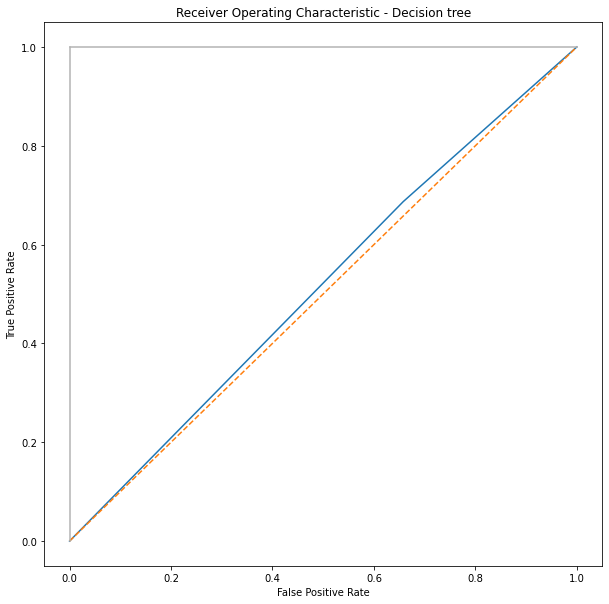

In [37]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_valid, y_pred3)
print('roc_auc_score for Decision tree: ', roc_auc_score(y_valid, y_pred3))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Decision tree')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

              precision    recall  f1-score   support

         0.0       0.95      0.68      0.79      2398
         1.0       0.55      0.92      0.69      1032

    accuracy                           0.75      3430
   macro avg       0.75      0.80      0.74      3430
weighted avg       0.83      0.75      0.76      3430



0.7513119533527697

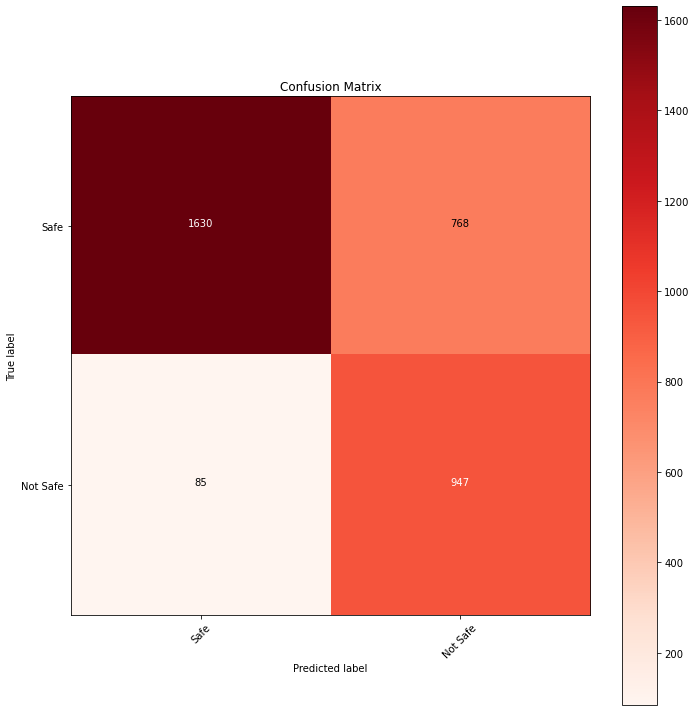

In [38]:
y_pred3 = model.predict(X_valid).reshape(-1)
#print (y_pred1[:5])
y_pred3 = np.round(y_pred1)
print ( classification_report(y_pred3, y_valid))
cm1 = confusion_matrix(y_pred3, y_valid)


def plot_confusion_matrix1(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
target_names = ["Safe", "Not Safe"]
plot_confusion_matrix1(cm1, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(y_valid, y_pred3)
